[View in Colaboratory](https://colab.research.google.com/github/aztecman/Move37/blob/master/SensorNetworks_Demo.ipynb)

In [0]:
# This demo is for School of AI move37
# forked from https://github.com/llSourcell/Sensor_Networks
# Credit to Siraj Raval

import numpy as np
import matplotlib.pyplot as plt
import random as rand
import cv2


class GridWorldMDP:

    # up, right, down, left
    _direction_deltas = [
        (-1, 0),
        (0, 1),
        (1, 0),
        (0, -1),
    ]
    _num_actions = len(_direction_deltas)

    def __init__(self,
                 reward_grid,
                 terminal_mask,
                 obstacle_mask,
                 action_probabilities,
                 no_action_probability):

        self._reward_grid = reward_grid
        self._terminal_mask = terminal_mask
        self._obstacle_mask = obstacle_mask
        self._T = self._create_transition_matrix(
            action_probabilities,
            no_action_probability,
            obstacle_mask
        )

    @property
    def shape(self):
        return self._reward_grid.shape

    @property
    def size(self):
        return self._reward_grid.size

    @property
    def reward_grid(self):
        return self._reward_grid

    def run_value_iterations(self, discount=1.0,
                             iterations=10):
        utility_grids, policy_grids = self._init_utility_policy_storage(iterations)

        utility_grid = np.zeros_like(self._reward_grid)
        for i in range(iterations):
            utility_grid = self._value_iteration(utility_grid=utility_grid)
            policy_grids[:, :, i] = self.best_policy(utility_grid)
            utility_grids[:, :, i] = utility_grid
        return policy_grids, utility_grids

    def run_policy_iterations(self, discount=1.0,
                              iterations=10):
        utility_grids, policy_grids = self._init_utility_policy_storage(iterations)

        policy_grid = np.random.randint(0, self._num_actions,
                                        self.shape)
        utility_grid = self._reward_grid.copy()

        for i in range(iterations):
            policy_grid, utility_grid = self._policy_iteration(
                policy_grid=policy_grid,
                utility_grid=utility_grid
            )
            policy_grids[:, :, i] = policy_grid
            utility_grids[:, :, i] = utility_grid
        return policy_grids, utility_grids

    def generate_experience(self, current_state_idx, action_idx):
        sr, sc = self.grid_indices_to_coordinates(current_state_idx)
        next_state_probs = self._T[sr, sc, action_idx, :, :].flatten()

        next_state_idx = np.random.choice(np.arange(next_state_probs.size),
                                          p=next_state_probs)

        return (next_state_idx,
                self._reward_grid.flatten()[next_state_idx],
                self._terminal_mask.flatten()[next_state_idx])

    def grid_indices_to_coordinates(self, indices=None):
        if indices is None:
            indices = np.arange(self.size)
        return np.unravel_index(indices, self.shape)

    def grid_coordinates_to_indices(self, coordinates=None):
        # Annoyingly, this doesn't work for negative indices.
        # The mode='wrap' parameter only works on positive indices.
        if coordinates is None:
            return np.arange(self.size)
        return np.ravel_multi_index(coordinates, self.shape)

    def best_policy(self, utility_grid):
        M, N = self.shape
        return np.argmax((utility_grid.reshape((1, 1, 1, M, N)) * self._T)
                         .sum(axis=-1).sum(axis=-1), axis=2)

    def _init_utility_policy_storage(self, depth):
        M, N = self.shape
        utility_grids = np.zeros((M, N, depth))
        policy_grids = np.zeros_like(utility_grids)
        return utility_grids, policy_grids

    def _create_transition_matrix(self,
                                  action_probabilities,
                                  no_action_probability,
                                  obstacle_mask):
        M, N = self.shape

        T = np.zeros((M, N, self._num_actions, M, N))

        r0, c0 = self.grid_indices_to_coordinates()

        T[r0, c0, :, r0, c0] += no_action_probability

        for action in range(self._num_actions):
            for offset, P in action_probabilities:
                direction = (action + offset) % self._num_actions

                dr, dc = self._direction_deltas[direction]
                r1 = np.clip(r0 + dr, 0, M - 1)
                c1 = np.clip(c0 + dc, 0, N - 1)

                temp_mask = obstacle_mask[r1, c1].flatten()
                r1[temp_mask] = r0[temp_mask]
                c1[temp_mask] = c0[temp_mask]

                T[r0, c0, action, r1, c1] += P

        terminal_locs = np.where(self._terminal_mask.flatten())[0]
        T[r0[terminal_locs], c0[terminal_locs], :, :, :] = 0
        return T

    def _value_iteration(self, utility_grid, discount=1.0):
        out = np.zeros_like(utility_grid)
        M, N = self.shape
        for i in range(M):
            for j in range(N):
                out[i, j] = self._calculate_utility((i, j),
                                                    discount,
                                                    utility_grid)
        return out

    def _policy_iteration(self, *, utility_grid,
                          policy_grid, discount=1.0):
        r, c = self.grid_indices_to_coordinates()

        M, N = self.shape

        utility_grid = (
            self._reward_grid +
            discount * ((utility_grid.reshape((1, 1, 1, M, N)) * self._T)
                        .sum(axis=-1).sum(axis=-1))[r, c, policy_grid.flatten()]
            .reshape(self.shape)
        )

        utility_grid[self._terminal_mask] = self._reward_grid[self._terminal_mask]

        return self.best_policy(utility_grid), utility_grid

    def _calculate_utility(self, loc, discount, utility_grid):
        if self._terminal_mask[loc]:
            return self._reward_grid[loc]
        row, col = loc
        return np.max(
            discount * np.sum(
                np.sum(self._T[row, col, :, :, :] * utility_grid,
                       axis=-1),
                axis=-1)
        ) + self._reward_grid[loc]

    def plot_policy(self, utility_grid, policy_grid=None):
        if policy_grid is None:
            policy_grid = self.best_policy(utility_grid)
        markers = "^>v<"
        marker_size = 200 // np.max(policy_grid.shape)
        marker_edge_width = marker_size // 10
        marker_fill_color = 'w'

        no_action_mask = self._terminal_mask | self._obstacle_mask

        utility_normalized = (utility_grid - utility_grid.min()) / \
                             (utility_grid.max() - utility_grid.min())

        utility_normalized = (255*utility_normalized).astype(np.uint8)

        utility_rgb = cv2.applyColorMap(utility_normalized, cv2.COLORMAP_JET)
        for i in range(3):
            channel = utility_rgb[:, :, i]
            channel[self._obstacle_mask] = 0

        plt.imshow(utility_rgb[:, :, ::-1], interpolation='none')

        for i, marker in enumerate(markers):
            y, x = np.where((policy_grid == i) & np.logical_not(no_action_mask))
            plt.plot(x, y, marker, ms=marker_size, mew=marker_edge_width,
                     color=marker_fill_color)

        y, x = np.where(self._terminal_mask)
        plt.plot(x, y, 'o', ms=marker_size, mew=marker_edge_width,
                 color=marker_fill_color)

        tick_step_options = np.array([1, 2, 5, 10, 20, 50, 100])
        tick_step = np.max(policy_grid.shape)/8
        best_option = np.argmin(np.abs(np.log(tick_step) - np.log(tick_step_options)))
        tick_step = tick_step_options[best_option]
        plt.xticks(np.arange(0, policy_grid.shape[1] - 0.5, tick_step))
        plt.yticks(np.arange(0, policy_grid.shape[0] - 0.5, tick_step))
        plt.xlim([-0.5, policy_grid.shape[0]-0.5])
        plt.xlim([-0.5, policy_grid.shape[1]-0.5])

In [0]:
class QLearner:
    '''A generic implementation of Q-Learning and Dyna-Q'''

    def __init__(self, *,
                 num_states,
                 num_actions,
                 learning_rate,
                 discount_rate=1.0,
                 random_action_prob=0.5,
                 random_action_decay_rate=0.99,
                 dyna_iterations=0):

        self._num_states = num_states
        self._num_actions = num_actions
        self._learning_rate = learning_rate
        self._discount_rate = discount_rate
        self._random_action_prob = random_action_prob
        self._random_action_decay_rate = random_action_decay_rate
        self._dyna_iterations = dyna_iterations

        self._experiences = []

        # Initialize Q to small random values.
        self._Q = np.zeros((num_states, num_actions), dtype=np.float)
        self._Q += np.random.normal(0, 0.3, self._Q.shape)

    def initialize(self, state):
        '''Set the initial state and return the learner's first action'''
        self._decide_next_action(state)
        self._stored_state = state
        return self._stored_action

    def learn(self, initial_state, experience_func, iterations=100):
        '''Iteratively experience new states and rewards'''
        all_policies = np.zeros((self._num_states, iterations))
        all_utilities = np.zeros_like(all_policies)
        for i in range(iterations):
            done = False
            self.initialize(initial_state)
            for j in range(iterations):
                state, reward, done = experience_func(self._stored_state,
                                                      self._stored_action)
                self.experience(state, reward)
                if done:
                    break

            policy, utility = self.get_policy_and_utility()
            all_policies[:, i] = policy
            all_utilities[:, i] = utility
        return all_policies, all_utilities

    def experience(self, state, reward):
        '''The learner experiences state and receives a reward'''
        self._update_Q(self._stored_state, self._stored_action, state, reward)

        if self._dyna_iterations > 0:
            self._experiences.append(
                (self._stored_state, self._stored_action, state, reward)
            )
            exp_idx = np.random.choice(len(self._experiences),
                                       self._dyna_iterations)
            for i in exp_idx:
                self._update_Q(*self._experiences[i])

        # determine an action and update the current state
        self._decide_next_action(state)
        self._stored_state = state

        self._random_action_prob *= self._random_action_decay_rate

        return self._stored_action

    def get_policy_and_utility(self):
        policy = np.argmax(self._Q, axis=1)
        utility = np.max(self._Q, axis=1)
        return policy, utility

    def _update_Q(self, s, a, s_prime, r):
        best_reward = self._Q[s_prime, self._find_best_action(s_prime)]
        self._Q[s, a] *= (1 - self._learning_rate)
        self._Q[s, a] += (self._learning_rate
                          * (r + self._discount_rate * best_reward))

    def _decide_next_action(self, state):
        if rand.random() <= self._random_action_prob:
            self._stored_action = rand.randint(0, self._num_actions - 1)
        else:
            self._stored_action = self._find_best_action(state)

    def _find_best_action(self, state):
        return int(np.argmax(self._Q[state, :]))

Final result of Value Iteration:
[[1. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 3.]]
[[ 0.56999141  0.71061644  0.83561644  1.        ]
 [ 0.44499134  0.66504707  0.52054795 -1.        ]
 [ 0.30913886  0.22232089  0.34732113  0.08650751]]


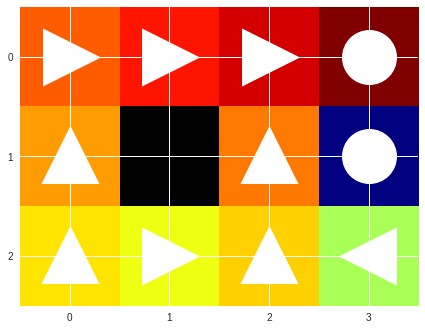

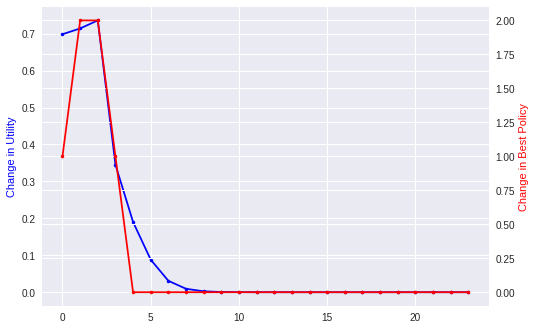

Final result of Policy Iteration:
[[1. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 3.]]
[[ 0.5699914   0.71061644  0.83561644  1.        ]
 [ 0.4449913   0.66504706  0.52054794 -1.        ]
 [ 0.30913874  0.22232075  0.34732108  0.08650741]]


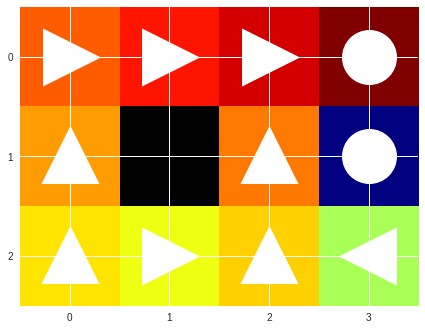

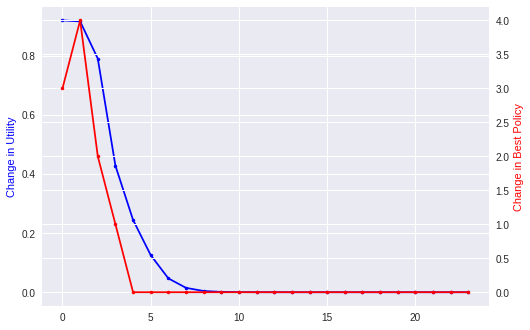

Final result of QLearning:
[[1. 1. 1. 2.]
 [0. 3. 0. 0.]
 [0. 3. 3. 3.]]
[[ 0.66496842  0.8586678   1.06651995  0.07391152]
 [ 0.48767834  0.20884858 -0.35161298  0.11031847]
 [ 0.3142553  -0.44128845 -0.48908525 -0.81469851]]


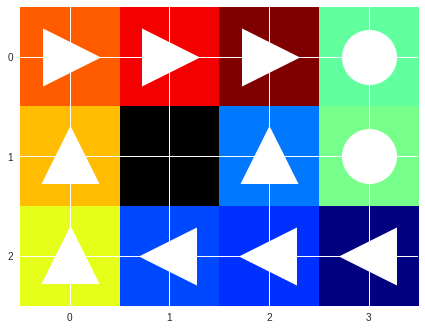

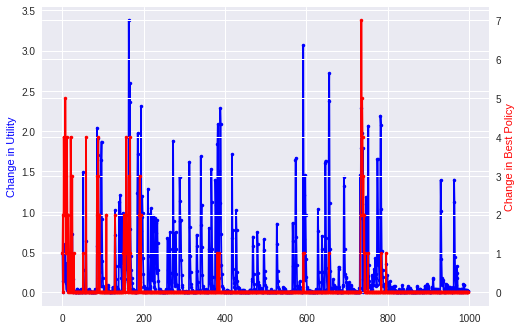

In [3]:
def plot_convergence(utility_grids, policy_grids):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    utility_ssd = np.sum(np.square(np.diff(utility_grids)), axis=(0, 1))
    ax1.plot(utility_ssd, 'b.-')
    ax1.set_ylabel('Change in Utility', color='b')

    policy_changes = np.count_nonzero(np.diff(policy_grids), axis=(0, 1))
    ax2.plot(policy_changes, 'r.-')
    ax2.set_ylabel('Change in Best Policy', color='r')


if __name__ == '__main__':
    shape = (3, 4)
    goal = (0, -1)
    trap = (1, -1)
    obstacle = (1, 1)
    start = (2, 0)
    default_reward = -0.1
    goal_reward = 1
    trap_reward = -1

    reward_grid = np.zeros(shape) + default_reward
    reward_grid[goal] = goal_reward
    reward_grid[trap] = trap_reward
    reward_grid[obstacle] = 0

    terminal_mask = np.zeros_like(reward_grid, dtype=np.bool)
    terminal_mask[goal] = True
    terminal_mask[trap] = True

    obstacle_mask = np.zeros_like(reward_grid, dtype=np.bool)
    obstacle_mask[1, 1] = True

    gw = GridWorldMDP(reward_grid=reward_grid,
                      obstacle_mask=obstacle_mask,
                      terminal_mask=terminal_mask,
                      action_probabilities=[
                          (-1, 0.1),
                          (0, 0.8),
                          (1, 0.1),
                      ],
                      no_action_probability=0.0)

    mdp_solvers = {'Value Iteration': gw.run_value_iterations,
                   'Policy Iteration': gw.run_policy_iterations}

    for solver_name, solver_fn in mdp_solvers.items():
        print('Final result of {}:'.format(solver_name))
        policy_grids, utility_grids = solver_fn(iterations=25, discount=0.5)
        print(policy_grids[:, :, -1])
        print(utility_grids[:, :, -1])
        plt.figure()
        gw.plot_policy(utility_grids[:, :, -1])
        plot_convergence(utility_grids, policy_grids)
        plt.show()

    ql = QLearner(num_states=(shape[0] * shape[1]),
                  num_actions=4,
                  learning_rate=0.8,
                  discount_rate=0.9,
                  random_action_prob=0.5,
                  random_action_decay_rate=0.99,
                  dyna_iterations=0)

    start_state = gw.grid_coordinates_to_indices(start)

    iterations = 1000
    flat_policies, flat_utilities = ql.learn(start_state,
                                             gw.generate_experience,
                                             iterations=iterations)

    new_shape = (gw.shape[0], gw.shape[1], iterations)
    ql_utility_grids = flat_utilities.reshape(new_shape)
    ql_policy_grids = flat_policies.reshape(new_shape)
    print('Final result of QLearning:')
    print(ql_policy_grids[:, :, -1])
    print(ql_utility_grids[:, :, -1])

    plt.figure()
    gw.plot_policy(ql_utility_grids[:, :, -1], ql_policy_grids[:, :, -1])
    plot_convergence(ql_utility_grids, ql_policy_grids)
    plt.show()